In [23]:
import math
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from google.colab import drive

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from PIL import Image

nlp = spacy.load("en_core_web_sm")
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation.replace("'", "")

# drive.mount("/content/gdrive")

In [24]:
reviews = pd.read_json("./datasets/reviews.json", lines=True)
metadata = pd.read_json("./datasets/metadata.json", lines=True)

reviews = reviews[["asin", "reviewerID", "overall", "summary", "reviewText"]]
metadata = metadata[["asin", "title", "description", "brand"]] # , "rank", "also_buy", "also_view"
reviews.rename(columns={"reviewerID": "id", "overall": "rating", "summary": "head", "reviewText": "body"}, inplace=True)

reviews.dropna(inplace=True)
metadata.dropna(inplace=True)

# metadata["rank"] = metadata["rank"].apply(str).apply(lambda x: (int(re.search(r"[0-9,]+", x).group(0).replace(",", ""))) if (re.fullmatch(r"[0-9,]+ in Beauty \& Personal Care \(", x) != None) else (-1))
metadata["description"] = [" ".join(map(str, li)) for li in metadata["description"]]

reviews["head"] = reviews["head"].apply(lambda x: x.translate(str.maketrans("", "", punctuations)).lower())
reviews["body"] = reviews["body"].apply(lambda x: x.translate(str.maketrans("", "", punctuations)).lower())
metadata["title"] = metadata["title"].apply(lambda x: x.translate(str.maketrans("", "", punctuations)).lower())
metadata["description"] = metadata["description"].apply(lambda x: x.translate(str.maketrans("", "", punctuations)).lower())
metadata["brand"] = metadata["brand"].apply(lambda x: x.translate(str.maketrans("", "", punctuations)).lower())

reviews["content"] = reviews["head"] + " " + reviews["body"]
metadata["content"] = metadata["title"] + " " + metadata["description"] + " " + metadata["brand"]
reviews.drop(columns=["head", "body"], inplace=True)
metadata.drop(columns=["title", "description", "brand"], inplace=True)

reviews.drop_duplicates(inplace=True)
metadata.drop_duplicates(inplace=True)

In [3]:
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 362013 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   asin     362013 non-null  object
 1   id       362013 non-null  object
 2   rating   362013 non-null  int64 
 3   content  362013 non-null  object
dtypes: int64(1), object(3)
memory usage: 13.8+ MB
None


In [4]:
print(metadata.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32488 entries, 0 to 32891
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   asin     32488 non-null  object
 1   content  32488 non-null  object
dtypes: object(2)
memory usage: 761.4+ KB
None


In [5]:
reviews.head()

,asin,id,rating,content
0,0143026860,A1V6B6TNIC10QE,1,one star great
1,0143026860,A2F5GHSXFQ0W6J,4,to reading about the negro baseball and this ...
2,0143026860,A1572GUYS7DGSR,4,worth the read this book was very informative ...
3,0143026860,A1PSGLFK1NSVO,5,good read i am already a baseball fan and knew...
4,0143026860,A6IKXKZMTKGSC,5,more than facts a good story read this was a g...


In [6]:
metadata.head()

,asin,content
0,6546546450,loud 'n cleartrade personal sound amplifier lo...
1,7178680776,no7 lift amp luminate triple action serum 50ml...
2,7250468162,no7 stay perfect foundation cool vanilla by no...
3,7367905066,wella koleston perfect hair colour 4444 medium...
4,7414204790,lacto calamine skin balance oil control 120 ml...


In [7]:
# doc = nlp(reviews["content"].values[4].replace("\\", ""))
# print(doc)

In [8]:
# for sent in doc.sents:
#   print(">", sent.start, sent.end, ">", sent)

In [9]:
# for sent in doc.sents:
#   for tok in sent:
#     print(tok, "|", tok.lemma_, "|", spacy.explain(tok.pos_), "|", tok.is_stop)
#   break

In [10]:
# for sent in doc.sents:
#   for tok in sent:
#     print(tok, "|", tok.morph)
#   break

In [11]:
# for ent in doc.ents:
#   print(ent, "|", ent.label_)

In [26]:
def get_stemmed(text):
  words = [PorterStemmer().stem(word) for word in word_tokenize(text) if word not in stop_words]
  return " ".join(words)

def get_word_clouds(df, column="content"):
  all = " ".join(df[column])
  plt.figure()
  word_cloud = WordCloud(background_color="white").generate(all)
  plt.imshow(word_cloud, interpolation="bilinear")
  plt.axis("off")
  plt.figure()
  word_cloud = WordCloud(background_color="white", mask=np.array(Image.open("./assets/amazon-logo.png")), max_font_size=32).generate(all)
  plt.imshow(word_cloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

def get_most_common_words(df, column="content"):
  temp = df[column].apply(get_stemmed)
  top_words = Counter([word for text in temp for word in text.split()]).most_common(25)
  plt.bar(*zip(*top_words))
  plt.xticks(rotation=-90)
  plt.show()

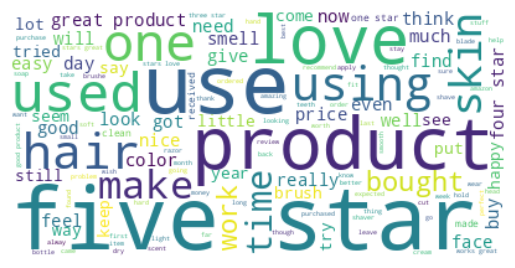

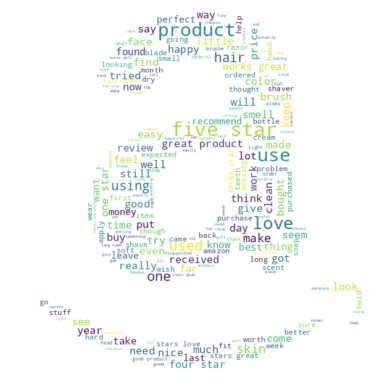

In [13]:
get_word_clouds(reviews)

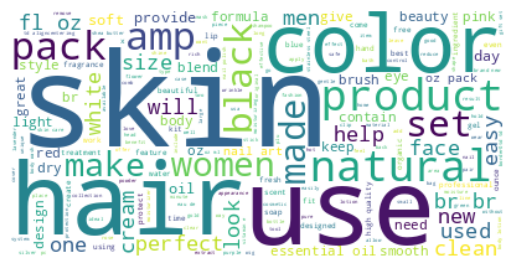

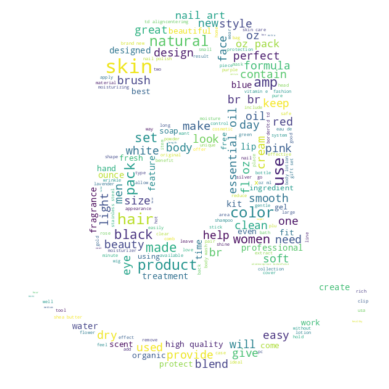

In [14]:
get_word_clouds(metadata)

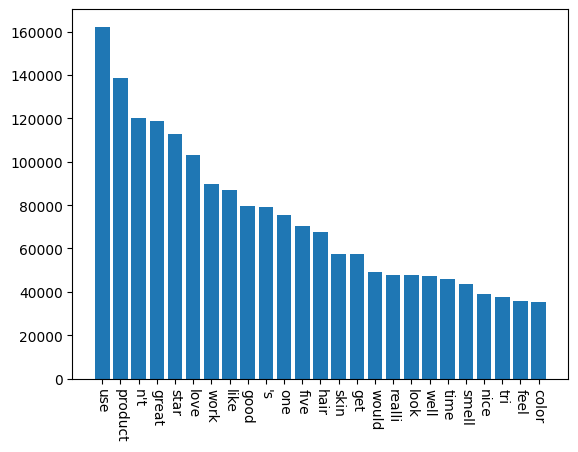

In [15]:
get_most_common_words(reviews)

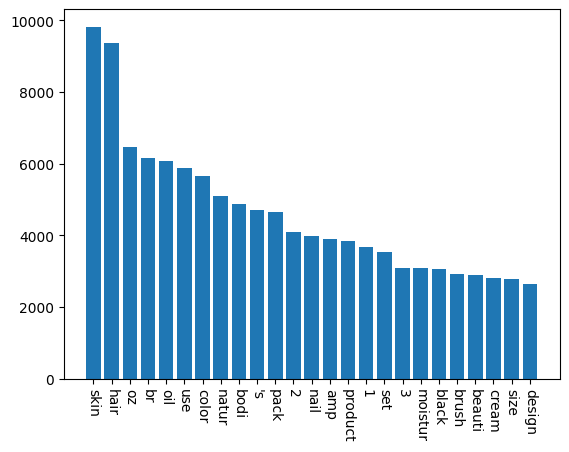

In [16]:
get_most_common_words(metadata)

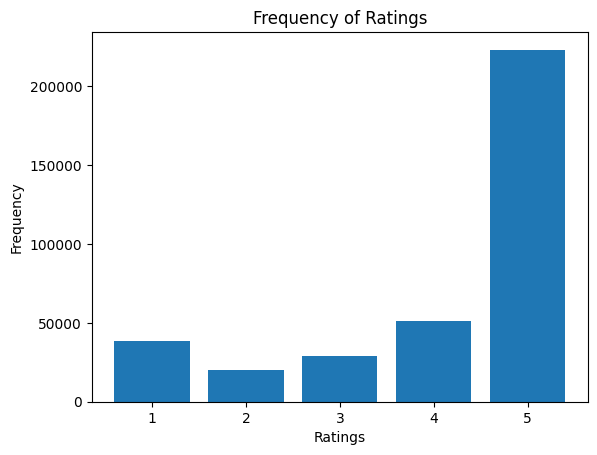

In [17]:
ratings_freq = reviews["rating"].value_counts().sort_index()
plt.bar(ratings_freq.index, ratings_freq.values)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Frequency of Ratings")
plt.show()

In [18]:
reviews["asin"].value_counts().head(10)

asin
B000FOI48G    8668
B000GLRREU    8338
1620213982    4789
B001QY8QXM    4544
B01DKQAXC0    4241
B00W259T7G    2839
B006IB5T4W    2788
B00005JS5C    2247
B00VF344X0    1957
B0067F28ZW    1845
Name: count, dtype: int64

In [27]:
reviews = reviews[reviews["rating"] > 3]
reviews.drop(columns=["rating"], inplace=True)
reviews = reviews.merge(metadata, on="asin", how="inner", suffixes=("_", "")).reset_index()
print(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269778 entries, 0 to 269777
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     269778 non-null  int64 
 1   asin      269778 non-null  object
 2   id        269778 non-null  object
 3   content_  269778 non-null  object
 4   content   269778 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB
None


In [63]:
metadata["content"] = metadata["content"].apply(get_stemmed)
tfidfv = TfidfVectorizer(max_features=2048, stop_words="english")
tfidf_metadata_matrix = tfidfv.fit_transform(metadata["content"])
tfidf_metadata = pd.DataFrame(tfidf_metadata_matrix.toarray(), columns=tfidfv.get_feature_names_out())

profiles = reviews.groupby("id").agg({"content_": " ".join, "content": " ".join}).reset_index()
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240817 entries, 0 to 240816
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        240817 non-null  object
 1   content_  240817 non-null  object
 2   content   240817 non-null  object
dtypes: object(3)
memory usage: 5.5+ MB


Top Recommendation bassed on USER_ID

In [65]:
query_id = "A0090495K0FTJUG4CPSA"
query_vector = tfidfv.transform(profiles[profiles["id"] == query_id]["content"])
cosineSimilarities = cosine_similarity(tfidf_metadata_matrix, query_vector).flatten()
related= cosineSimilarities.argsort()[:-10:-1]
for i in related:
  print(metadata["asin"][i])

B00OY9I2JE
B0103VRTD6
B00AWVM9JW
B012Z1DM7O
B00QG45UUO
B00LM2R3WS
B005JEVZKQ
B00QA6WVA0
B013ALH26U
